In [457]:
import random
import numpy as np 
import pandas as pd 
import os
import struct
%matplotlib inline
import random
import matplotlib.pyplot as plt
from array import array
from os.path  import join
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte
/kaggle/input/fasterrcnn2/alexnet-owt-7be5be79.pth
/kaggle/input/fasterrcnn1/vgg16-397923af.pth


In [458]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath, test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

In [459]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

In [460]:
input_path = '/kaggle/input/mnist-dataset'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

In [461]:
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

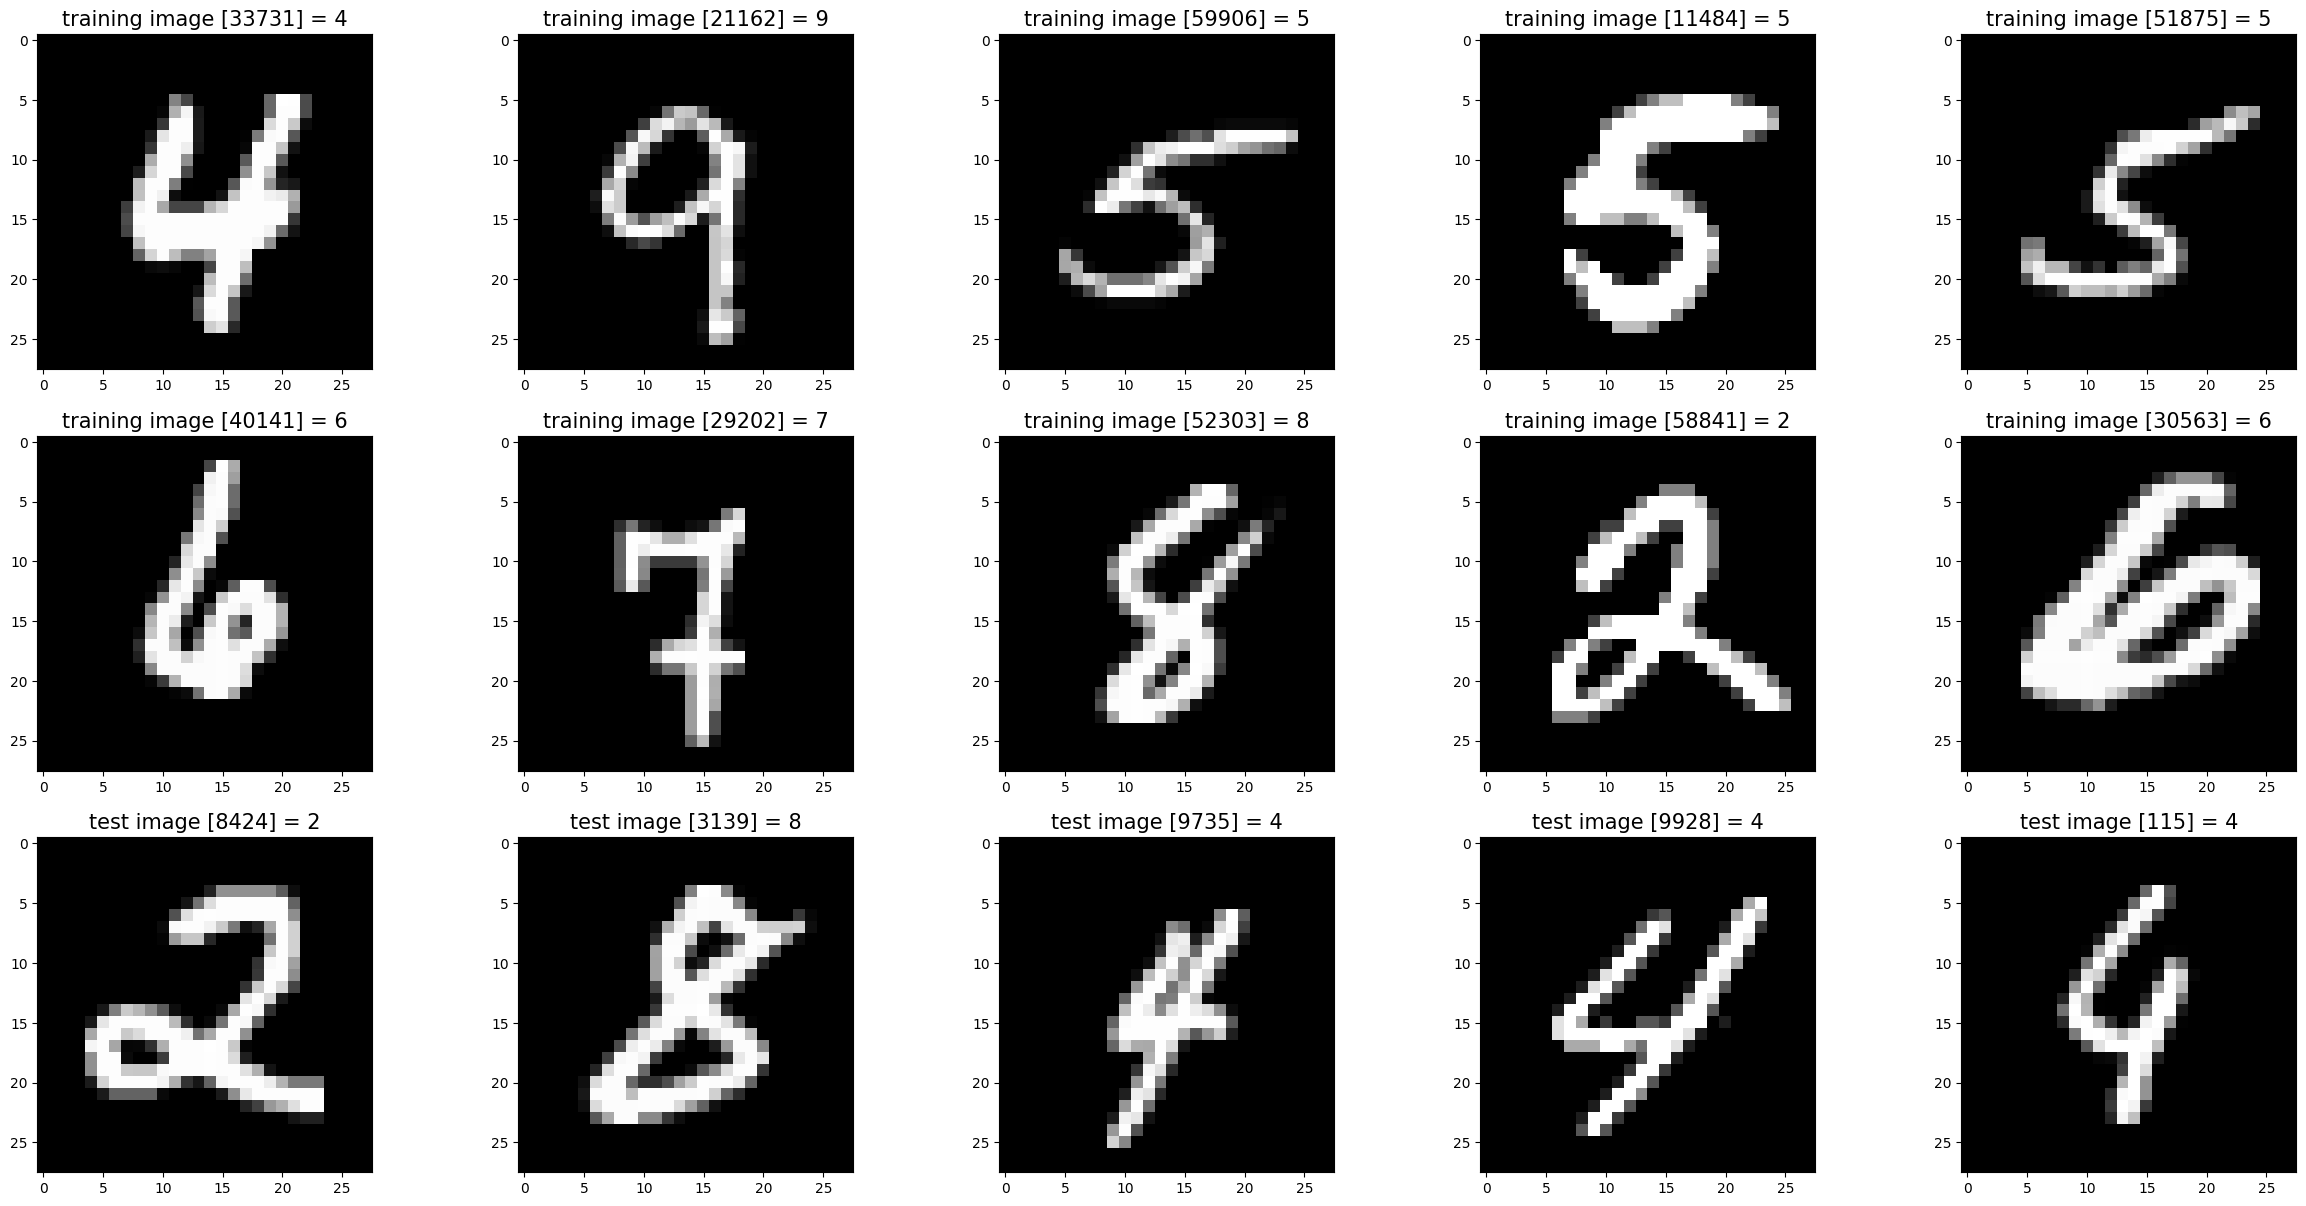

In [462]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

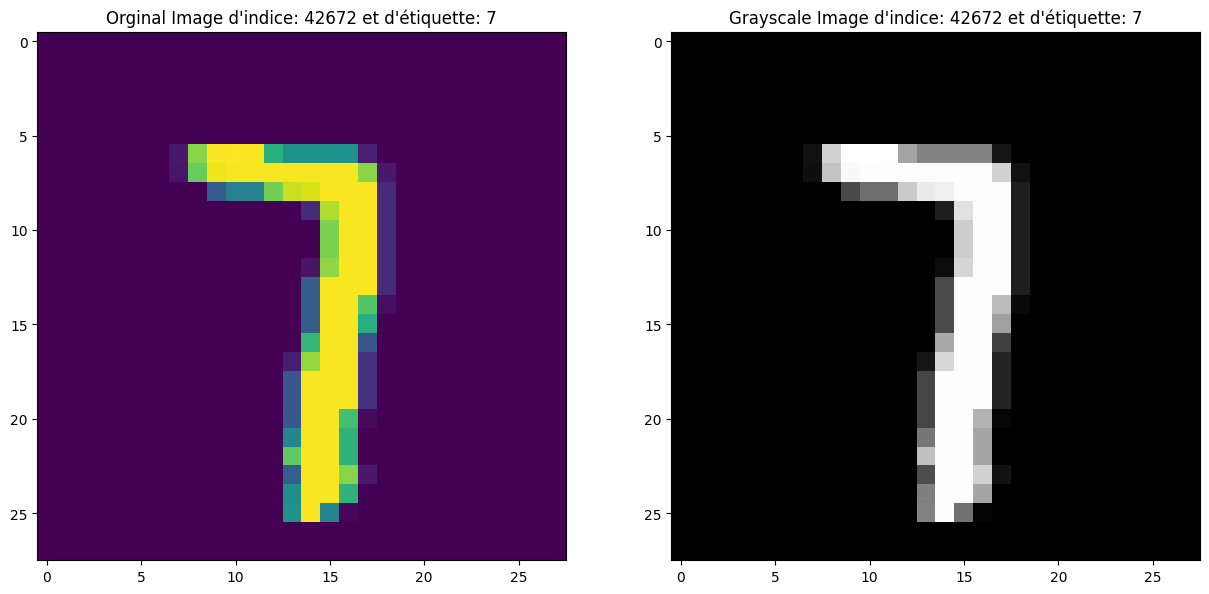

In [463]:
plt.figure(figsize=(15,10))
r = random.randint(0, 60000)
image = x_train[r]
label = y_train[r]
plt.subplot(1, 2, 1)        
plt.imshow(image)
plt.title("Orginal Image d'indice: " + str(r) + " et d'étiquette: " + str(label))
plt.subplot(1, 2, 2)        
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Grayscale Image d'indice: " + str(r) + " et d'étiquette: " + str(label))
plt.show()

In [464]:
mui_labels = np.unique(y_train)
print(mui_labels)

[0 1 2 3 4 5 6 7 8 9]


In [465]:
a=np.array(x_train)
r=a.shape
r

(60000, 28, 28)

In [466]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [467]:
l=np.array(x_test)
n=np.shape(l)
n

(10000, 28, 28)

# **PyTorch CNN:**

In [ ]:
import struct
import numpy as np
from array import array
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [ ]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = np.array(self.images[index], dtype=np.uint8).reshape(28, 28, 1)
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath, transform=None):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
        self.transform = transform

In [ ]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath, transform=None):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
        self.transform = transform

    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)

        train_dataset = MnistDataset(x_train, y_train, transform=self.transform)
        test_dataset = MnistDataset(x_test, y_test, transform=self.transform)

        return train_dataset, test_dataset


In [468]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)) 
])

batch_size = 2
mnist_dataloader = MnistDataloader('/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
                                   '/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
                                   '/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
                                   '/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte',
                                   transform=transform)

train_dataset, test_dataset = mnist_dataloader.load_data()
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [469]:

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 0.702
[1,  4000] loss: 0.164
[1,  6000] loss: 0.139
[1,  8000] loss: 0.116
[1, 10000] loss: 0.108
[1, 12000] loss: 0.090
[1, 14000] loss: 0.075
[1, 16000] loss: 0.060
[1, 18000] loss: 0.067
[1, 20000] loss: 0.069
[1, 22000] loss: 0.064
[1, 24000] loss: 0.057
[1, 26000] loss: 0.060
[1, 28000] loss: 0.062
[1, 30000] loss: 0.064
[2,  2000] loss: 0.047
[2,  4000] loss: 0.050
[2,  6000] loss: 0.044
[2,  8000] loss: 0.038
[2, 10000] loss: 0.035
[2, 12000] loss: 0.033
[2, 14000] loss: 0.047
[2, 16000] loss: 0.053
[2, 18000] loss: 0.034
[2, 20000] loss: 0.044
[2, 22000] loss: 0.032
[2, 24000] loss: 0.038
[2, 26000] loss: 0.036
[2, 28000] loss: 0.040
[2, 30000] loss: 0.028
Finished Training


In [497]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
correct_total = 0
total_total = 0
ground_truth_list =[]
predicted_list=[]

In [499]:
for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    correct_batch = (predicted == labels).sum().item()
    total_batch = labels.size(0)
    correct_total += correct_batch
    total_total += total_batch
    ground_truth_list.extend([classes[label] for label in labels])
    predicted_list.extend([classes[pred] for pred in predicted])

In [500]:
data = {'GroundTruth': ground_truth_list, 'Predicted': predicted_list}
df = pd.DataFrame(data)
print(df)

     GroundTruth Predicted
0              7         7
1              2         2
2              1         1
3              0         0
4              4         4
...          ...       ...
9995           2         2
9996           3         3
9997           4         4
9998           5         5
9999           6         6

[10000 rows x 2 columns]


In [501]:
accuracy = correct_total / total_total * 100
print(f'Accuracy on the test images: {accuracy:.2f}%')

Accuracy on the test images: 98.91%


# **Faster R-CNN**

In [472]:
!mkdir -p /root/.cache/torch/hub/checkpoints
!cp /kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth

In [473]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms
import numpy as np
import struct
from array import array

In [474]:
class FasterRCNNNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(FasterRCNNNet, self).__init__()
        self.faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = self.faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
        self.faster_rcnn_model.roi_heads.box_predictor = nn.Linear(in_features, num_classes)
    def load_pretrained_weights(self, model_path):
        state_dict = torch.load(model_path)
        mapping_dict = {
            "conv1.weight": "backbone.body.conv1.weight",
            "bn1.weight": "backbone.body.bn1.weight",
        }
        adjusted_state_dict = {}
        for key, value in state_dict.items():
            if key in mapping_dict:
                adjusted_key = mapping_dict[key]
                adjusted_state_dict[adjusted_key] = value
        self.faster_rcnn_model.load_state_dict(adjusted_state_dict, strict=False)
    def forward(self, images, targets=None):
        if self.training and targets is not None:
            targets = [{k: v for k, v in target.items()} for target in targets]
            loss_dict = self.faster_rcnn_model(images, targets)
            return sum(loss for loss in loss_dict.values())
        else:
            return self.faster_rcnn_model(images)

In [475]:
class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
    def forward(self, x):
        return self.cls_score(x)

In [476]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        height, width = image.shape[-2:]
        box = torch.tensor([0, 0, width, height], dtype=torch.float32)

        sample = {
            "images": image,
            "boxes": box,
            "labels": torch.tensor(label, dtype=torch.int64)
        }
        return sample


In [477]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath, transform=None):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
        self.transform = transform
    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img
        return images, labels
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        train_dataset = MnistDataset(x_train, y_train, transform=self.transform)
        test_dataset = MnistDataset(x_test, y_test, transform=self.transform)
        return train_dataset, test_dataset

In [478]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_dataloader = MnistDataloader(
    '/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
    '/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
    '/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
    '/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte',
    transform=transform
)

batch_size = 2
train_dataset, test_dataset = mnist_dataloader.load_data()
mnist_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
mnist_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [479]:
num_classes = 10
faster_rcnn_net = FasterRCNNNet(num_classes)
model_path = "/kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
faster_rcnn_net.load_pretrained_weights(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
faster_rcnn_net.to(device)
optimizer = optim.Adam(faster_rcnn_net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CrossEntropyLoss()

In [480]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for batch in dataloader:
        images = batch["images"].to(device)
        boxes = batch["boxes"].to(device)
        labels = batch["labels"].to(device)
        targets = [{"boxes": boxes, "labels": labels}]
        optimizer.zero_grad()
        outputs = model(images, targets)
        loss = sum(outputs.values())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)


In [481]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_samples
    return avg_loss, accuracy

In [482]:
# for epoch in range(num_epochs):
#     train_loss = train_one_epoch(faster_rcnn_net, mnist_train, optimizer, criterion, device)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}")
#     eval_loss, accuracy = evaluate(faster_rcnn_net, mnist_test, criterion, device)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {eval_loss:.4f}, Accuracy: {accuracy:.4f}")

# **fine tuning**

In [483]:
!mkdir -p /root/.cache/torch/hub/checkpoints
!cp /kaggle/input/fasterrcnn2/alexnet-owt-7be5be79.pth /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
!cp /kaggle/input/fasterrcnn1/vgg16-397923af.pth /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth

In [484]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as F

In [485]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = np.array(self.images[index], dtype=np.uint8).reshape(28, 28, 1)
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [486]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath, transform=None):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
        self.transform = transform

    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        train_dataset = MnistDataset(x_train, y_train, transform=self.transform)
        test_dataset = MnistDataset(x_test, y_test, transform=self.transform)
        return train_dataset, test_dataset

In [487]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_dataloader = MnistDataloader('/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte',
                                   '/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte',
                                   '/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte',
                                   '/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte',
                                   transform=transform)

train_dataset, test_dataset = mnist_dataloader.load_data()
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [488]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn = CNN().to(device)

In [489]:
class VGG16OneChannel(nn.Module):
    def __init__(self):
        super(VGG16OneChannel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model_vgg16_one_channel = VGG16OneChannel().to(device)

In [490]:
class alexnetChannel(nn.Module):
    def __init__(self):
        super(alexnetChannel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model_alexnet = alexnetChannel().to(device)

In [491]:
def fine_tune(model, train_loader, test_loader, num_epochs=5, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Accuracy: {accuracy}")

In [493]:
# print("Fine-tune AlexNet")
# fine_tune(model_alexnet, train_loader, test_loader)

# print("Fine-tune CNN")
# fine_tune(model_cnn, train_loader, test_loader)

# print(" Fine-tune VGG16")
# fine_tune(model_vgg16_one_channel, train_loader, test_loader)